In [1]:
import numpy as np
from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
import kmapper as km
from kmapper.cover import Cover

import networkx as nx
from community import best_partition # this is not part of networkx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio
import plotly
import plotly.graph_objs as go

import os

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    
def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

# Dimension reduction and clustering libraries
# import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [3]:
'''Loading the data'''
widths = []
heights = []
target = []

directory = '/home/garner1/Work/dataset/cellImages/Cancer'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    width = rmax-rmin
    height = cmax-cmin
    widths.append(width)
    heights.append(height)
    target.append(0)

directory = '/home/garner1/Work/dataset/cellImages/Immuno'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    width = rmax-rmin
    height = cmax-cmin
    widths.append(width)
    heights.append(height)
    target.append(1)

directory = '/home/garner1/Work/dataset/cellImages/Other'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    width = rmax-rmin
    height = cmax-cmin
    widths.append(width)
    heights.append(height)
    target.append(2)
    
Mwidths = max(widths)
Mheights = max(heights)

nullimg = np.zeros(Mwidths,Mheights)
images = []
directory = '/home/garner1/Work/dataset/cellImages/Cancer'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    padwidth = int(Mwidths-(rmax-rmin))
    padheight = int(Mheights-(cmax-cmin))
    newimg = np.pad(img[rmin:rmax,cmin:cmax],((0,padwidth),(0,padheight)),'constant', constant_values=(0))
    images.append(newimg)
directory = '/home/garner1/Work/dataset/cellImages/Immuno'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    padwidth = int(Mwidths-(rmax-rmin))
    padheight = int(Mheights-(cmax-cmin))
    newimg = np.pad(img[rmin:rmax,cmin:cmax],((0,padwidth),(0,padheight)),'constant', constant_values=(0))
    images.append(newimg)
directory = '/home/garner1/Work/dataset/cellImages/Other'
for img in os.listdir(directory):
    filename = os.path.join(directory, img)
    img = imageio.imread(filename)
    rmin, rmax, cmin, cmax = bbox(img)
    padwidth = int(Mwidths-(rmax-rmin))
    padheight = int(Mheights-(cmax-cmin))
    newimg = np.pad(img[rmin:rmax,cmin:cmax],((0,padwidth),(0,padheight)),'constant', constant_values=(0))
    images.append(newimg)

print(len(images))

# sns.set(style='white', context='notebook', rc={'figure.figsize':(168,120)})
# fig, ax_array = plt.subplots(30,20)
# axes = ax_array.flatten()
# for i, ax in enumerate(axes):
#     ax.imshow(images[i], cmap='gray_r')
# plt.setp(axes, xticks=[], yticks=[], frame_on=False)
# plt.tight_layout(h_pad=0.5, w_pad=0.01)

600


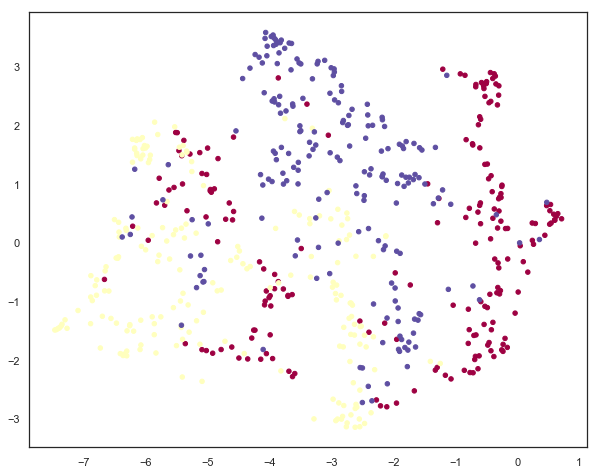

In [4]:
'''2D visualization of annotated data'''
data = np.zeros((Mwidths*Mheights,len(images)))
for ind in range(len(images)): data[:,ind] = images[ind].flatten() # from 2D arrays to 1D arrays
data = data.transpose()
#####
d2_embedding = umap.UMAP(random_state=42).fit_transform(data)
#####
sns.set(style='white', rc={'figure.figsize':(10,8)})
plt.scatter(d2_embedding[:, 0], d2_embedding[:, 1], c=np.asarray(target), s=20, cmap='Spectral');

In [138]:
'''3D visualization of annotated data'''
data = np.zeros((Mwidths*Mheights,len(images)))
for ind in range(len(images)): data[:,ind] = images[ind].flatten() # from 2D arrays to 1D arrays
data = data.transpose()
######
d3_embedding = umap.UMAP(n_neighbors=30,min_dist=0.0,n_components=3,random_state=42,).fit_transform(data)
######
# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x=d3_embedding[:,0],  # <-- Put your data instead
    y=d3_embedding[:,1],  # <-- Put your data instead
    z=d3_embedding[:,2],  # <-- Put your data instead
    mode='markers',
    marker=dict(color=np.asarray(target),size=5, opacity=1)
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

mydata = [trace]

plot_figure = go.Figure(data=mydata, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

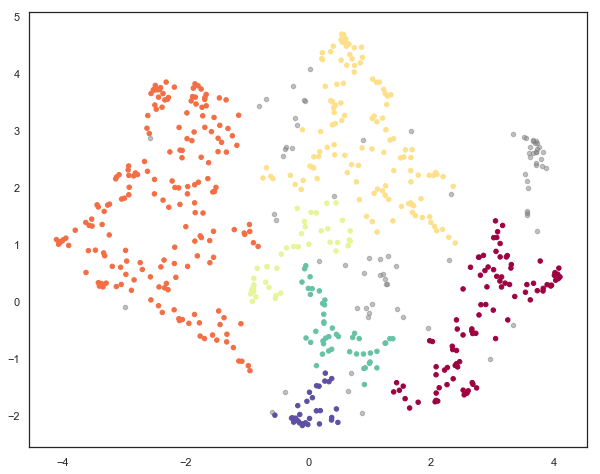

In [156]:
'''
HDBSCAN clusters in 2D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
'''
data = np.zeros((Mwidths*Mheights,len(images)))
for ind in range(len(images)): data[:,ind] = images[ind].flatten() # from 2D arrays to 1D arrays
data = data.transpose()

data = PCA(n_components=100).fit_transform(data) #intermediate dim reduction

d2_embedding = umap.UMAP(random_state=42).fit_transform(data)
d2_labels = hdbscan.HDBSCAN(min_samples=3,min_cluster_size=30).fit_predict(d2_embedding)

sns.set(style='white', rc={'figure.figsize':(10,8)})
clustered = (d2_labels >= 0)
plt.scatter(d2_embedding[~clustered, 0],
            d2_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=20,
            alpha=0.5)
plt.scatter(d2_embedding[clustered, 0],
            d2_embedding[clustered, 1],
            c=d2_labels[clustered],
            s=20,
            cmap='Spectral');

In [191]:
'''
HDBSCAN clusters in 3D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
PCA reduction might not be a good idea because shape space is non-linear and the linear reduction could distort distances and later clustering
'''
data = np.zeros((Mwidths*Mheights,len(images)))
for ind in range(len(images)): data[:,ind] = images[ind].flatten() # from 2D arrays to 1D arrays
data = data.transpose()

# data = PCA(n_components=n_components).fit_transform(data) #intermediate dim reduction

d3_embedding = umap.UMAP(n_neighbors=30,min_dist=0.1,n_components=3,random_state=42,).fit_transform(data)

d3_labels = hdbscan.HDBSCAN(min_samples=3,min_cluster_size=60).fit_predict(d3_embedding)

import plotly.graph_objects as go

fig = go.Figure()
size = 2
for cluster in set(d3_labels):
    clustered = (d3_labels == cluster)
    fig.add_trace(go.Scatter3d(
        x=d3_embedding[clustered,0],  # <-- Put your data instead
        y=d3_embedding[clustered,1],  # <-- Put your data instead
        z=d3_embedding[clustered,2],  # <-- Put your data instead
        name="cluster "+str(cluster),
        mode="markers",
        marker=dict(color=cluster+1,size=size+cluster, opacity=1)
    ))
fig.update_layout(title_text="HDBSCAN clusters in 3D "+str(n_components),
                  title_font_size=30)
fig.show()
##########
clustered = (d3_labels >= 0)
print('The percentage of clustered data points is '+str(np.sum(clustered) *1.0/ data.shape[0]*100)+'%')


The percentage of clustered data points is 86.16666666666667%


In [184]:
%%bash
rm cluster_*.png

In [185]:
from itertools import compress

for label in set(d3_labels): 
    clustered = (d3_labels == label)
    images_in_cluster = list(compress(images, clustered))
    sns.set(style='white', context='notebook', rc={'figure.figsize':(168,120)})
    n_cols = 30
    n_rows = len(images)/n_cols + 1
    fig, ax_array = plt.subplots(n_rows,n_cols)
    axes = ax_array.flatten()
    for i, ax in enumerate(axes):
        try:
            ax.imshow(images_in_cluster[i], cmap='gray_r')
        except IndexError:
            i > len(images_in_cluster)
            pass
    fig.suptitle('Cluster# '+str(label), fontsize=300)
    plt.setp(axes, xticks=[], yticks=[], frame_on=False)
#     plt.tight_layout(h_pad=0.5, w_pad=0.01)
    plt.savefig('cluster_'+str(label)+'.png')